# Sentinel 2 Water Observations from Space

**Description:** This Python notebook allows users to directly interact with a Sentinel 2 remote sensing data to perform water classification. The following steps will allow users to connect to a data cube, define the analysis location and time period (extent of latitude/longitude and dates), and then run the Australian Water Observations from Space (WOFS) algorithm. 

The outputs of the WOFS algorithm include static and time series pixel-level water observations for any pixel. These results provide critical information for water management that will allow users to assess water cycle dynamics, historical water extent and the risk of floods and droughts.
****
Ensure:
- Sentinel 2 cube is saved and configured. 
- 'module load dea-env'
*****
This notebook is based on a CEOS notebook https://github.com/ceos-seo/data_cube_notebooks/blob/master/water_detection.ipynb 

The water classifier is based on Mueller, et al. (2015) "Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia." Remote Sensing of Environment. https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py

## Initial set up 

In [1]:
#Import libraries
%pylab notebook

from datacube import Datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict

import numpy as np
import warnings
import gc
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl

Populating the interactive namespace from numpy and matplotlib


In [2]:
#link to Sentinel 2 datacube
dc = Datacube()
s2dc = Datacube(config = '/g/data/u46/users/ext547/working/sentinel_2/Sentinel2_datacube.conf')

In [3]:
#Create functions

#Define function to create a RGB composite images of all scenes within an array as subplots
def three_band_image_subplots(ds, bands, num_cols, figsize = [20,80], left  = 0.125, 
                              right = 0.9, bottom = 0.1, top = 0.9, 
                              wspace = 0.2, hspace = 0.4):
    '''
    threeBandImage_subplots takes three spectral bands and multiple time steps, 
    and plots them on the RGB bands of an image. 
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause and Erin Telfer
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    num_cols - number of columns for the subplot
    
    Optional:
    figsize - dimensions for the output figure
    left  - the space on the left side of the subplots of the figure
    right - the space on the right side of the subplots of the figure
    bottom - the space on the bottom of the subplots of the figure
    top - the space on the top of the subplots of the figure
    wspace - the amount of width reserved for blank space between subplots
    hspace - the amount of height reserved for white space between subplots
    '''
    # Find the number of rows/columns we need, based on the number of time steps in ds
    fig = plt.figure(figsize = figsize)
    timesteps = ds.time.size
    num_rows = int(np.ceil(timesteps/num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    fig.subplots_adjust(left  = left, right = right, bottom = bottom, top = top, 
                        wspace = wspace, hspace = hspace)
   
    try: #loop through all scenes, prepare imagery and create subplots
        for i, ax in enumerate(fig.axes):
            rgb = ds.isel(time =i).to_array(dim='color').sel(color=bands).transpose('y', 'x', 'color')
            rgb=rgb.where(rgb>=0)
            fake_saturation = 6000.0
            rgb = rgb.astype('double')
            clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
            max_val = clipped_visible.max(['y', 'x'])
            scaled = (clipped_visible / max_val) 
            ax.imshow(scaled, interpolation = 'nearest') #plot image as subplot
            ax.set_title(str(scaled.time.values)[0:10])
    except IndexError: #if there are an odd number of plots, this code will allow plotting of images
        fig.delaxes(ax)
        plt.draw() 


def water_classifier(dataset_in):
    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)

    def _run_regression(blue, green, red, nir, swir1, swir2):
        """
        Water classifier. Regression analysis based on Australia training data.
        """

        # Compute normalized ratio indices
        ndi_52 = _band_ratio(swir1, green)
        ndi_43 = _band_ratio(nir, red)
        ndi_72 = _band_ratio(swir2, green)

        #classified = np.ones(shape, dtype='uint8')

        classified = np.full(shape, no_data, dtype='uint8')

        # Start with the tree's left branch, finishing nodes as needed

        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = blue <= 2083.5
        classified[r1 & ~r2] = 0  #Node 3

        r3 = swir2 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1  #Node 6
        classified[_tmp2 & ~r4] = 0  #Node 7

        r5 = blue <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1  #Node 10
        classified[_tmp2 & ~r6] = 0  #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = blue <= 379
        classified[_tmp2 & r8] = 1  #Node 14
        classified[_tmp2 & ~r8] = 0  #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1  #Node 17
        _tmp &= ~r9

        r10 = blue <= 473
        classified[_tmp & r10] = 1  #Node 19
        classified[_tmp & ~r10] = 0  #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()

        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = blue <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0  #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0  #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1  #Node 27

        _tmp &= ~r14

        r15 = red <= 364.5
        _tmp2 = _tmp & r15

        r16 = blue <= 129.5
        classified[_tmp2 & r16] = 1  #Node 31
        classified[_tmp2 & ~r16] = 0  #Node 32

        _tmp &= ~r15

        r17 = blue <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1  #Node 33
        classified[_tmp2] = 0  #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0  #Node 36
        _tmp &= r18

        r19 = blue <= 249.5
        classified[_tmp & ~r19] = 0  #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0  #Node 40
        _tmp &= r20

        r21 = red <= 364.5
        classified[_tmp & ~r21] = 0  #Node 42
        _tmp &= r21

        r22 = blue <= 129.5
        classified[_tmp & r22] = 1  #Node 44
        classified[_tmp & ~r22] = 0  #Node 45

        # Completed regression tree

        return classified
    
    blue = dataset_in.blue
    green = dataset_in.green
    red = dataset_in.red
    nir = dataset_in.nir
    swir1 = dataset_in.swir1
    swir2 = dataset_in.swir2

    dtype = blue.values.dtype 
    shape = blue.values.shape

    no_data =-9999

    classified = _run_regression(blue.values, green.values, red.values, nir.values, swir1.values, swir2.values)

    classified_clean=classified.astype('float64')
    
    y = dataset_in.y
    x = dataset_in.x

    time = None
    coords = None
    dims = None

    time = dataset_in.time
    coords = [time, y, x]
    dims = ['time', 'y', 'x']

    data_array = xr.DataArray(classified_clean, coords=coords, dims=dims)

    dataset_out = xr.Dataset(
            {
                'wofs': data_array
            }, coords={'time': time,
                       'y': y,
                       'x': x})
    return dataset_out

# Query details

In [4]:
#Enter coordinates and time of interest

lat_in = (-35.25, -35.35)
lon_in = (149.05, 149.17)
time_in = ('2016-01-01', '2017-12-31')

# Explore Sentinel two data

## Query Sentinel Cube

In [5]:
#Define details of interest
query = {'lat': lat_in,
        'lon': lon_in,
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':time_in,}
print(query)
s2_bands_of_interest = ['blue', 
                     'green', 
                     'red', 
                     'nir1', 
                     'swir1', 
                     'swir2', 
                     'pixel_quality',]

{'lat': (-35.25, -35.35), 'lon': (149.05, 149.17), 'output_crs': 'EPSG:3577', 'resolution': (-10, 10), 'time': ('2016-01-01', '2017-12-31')}


In [6]:
#load Sentinel 2 data
s2_dataset = s2dc.load(product='s2a_ard_granule', measurements = s2_bands_of_interest,
                  group_by='solar_day', **query)
s2_dataset = s2_dataset.rename({'nir1':'nir'})
s2_dataset

<xarray.Dataset>
Dimensions:        (time: 63, x: 1229, y: 1248)
Coordinates:
  * time           (time) datetime64[ns] 2016-01-01T00:09:15.704000 ...
  * y              (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x              (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    blue           (time, y, x) int16 597 481 532 547 597 623 581 559 562 ...
    green          (time, y, x) int16 706 610 637 634 752 658 659 689 664 ...
    red            (time, y, x) int16 764 702 705 725 752 779 766 801 698 ...
    nir            (time, y, x) int16 1908 2260 2273 2056 2107 2203 2589 ...
    swir1          (time, y, x) int16 1865 1794 1794 1743 1743 1810 1810 ...
    swir2          (time, y, x) int16 1187 1246 1246 1173 1173 1218 1218 ...
    pixel_quality  (time, y, x) uint8 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 ...
Attributes:
    crs:      EPSG:3577

## Filter scenes using pixel quality

A pixel quality dataset is provided alongside the spectral data, which can be used to filter out noisy pixels. The key things we want to filter are clouds and shadows.

The pixel quality field contains values from 0 to 5.

    
| Value | Description |
|-------|-------------|
| 0 | Null |
| 1 | Valid |
| 2 | Cloud |
| 3 | Cloud shadow |
| 4 | Snow |
| 5 | Water |
    
In the Sentinel data, clear pixels are denoted as 1 in the pixel quality mask. We can use this to filter a cloudy image.

In [7]:
clear_pixels = np.logical_and(np.logical_and(s2_dataset.pixel_quality != 0, s2_dataset.pixel_quality != 2), s2_dataset.pixel_quality != 3)
s2_clear_dataset = s2_dataset.where(clear_pixels)

## Plot subplots containing all scenes loaded for specified date range and location

In [8]:
# #Use function, defined above, to create three band composites subplot
# three_band_image_subplots(s2_clear_dataset, ['swir1','nir', 'green'], 2)

## Use water classifier and create an image of WOfS

In [9]:
#Use water clasifier function created above
warnings.filterwarnings('ignore') #turn off warnings
s2_water_class = water_classifier(s2_clear_dataset)#_subset) #use function
warnings.filterwarnings('always') #turn on warnings
print(s2_water_class)

<xarray.Dataset>
Dimensions:  (time: 63, x: 1229, y: 1248)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01T00:09:15.704000 ...
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    wofs     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


In [10]:
#normalise each pixel by wether this pixel has been clear over time
s2_total_water_obs = s2_water_class.wofs.sum(dim='time') #create array that sums water obs for each pixel
s2_count = s2_clear_dataset.pixel_quality.count(dim='time') #create array that sums clear obs for each pixel
s2_wofs = ((s2_total_water_obs/s2_count)*100) #divide water obs by clear pixel to create wofs

In [11]:
#Set up colour ramp details to meet DEA specified colour details
wofs_cmap = mpl.colors.ListedColormap(['#000000', '#e38400',
                                       '#e3df00', '#a6e300', '#62e300', 
                                       '#00e384', '#00e3c8', '#00c5e3', 
                                       '#005fe3', '#000fe3', '#5700e3'])
wofs_bounds = [0,5.0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# wofs_cmap = mpl.colors.ListedColormap(['#000000', '#8e0101', '#cf2200', '#e38400',
#                                        '#e3df00', '#a6e300', '#62e300', '#00e32d',
#                                        '#00e384', '#00e3c8', '#00c5e3', '#0097e3', 
#                                        '#005fe3', '#000fe3', '#5700e3'])
# wofs_bounds = [0,0.2,0.5,1.0,2.0,5.0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]




wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)

<IPython.core.display.Javascript object>


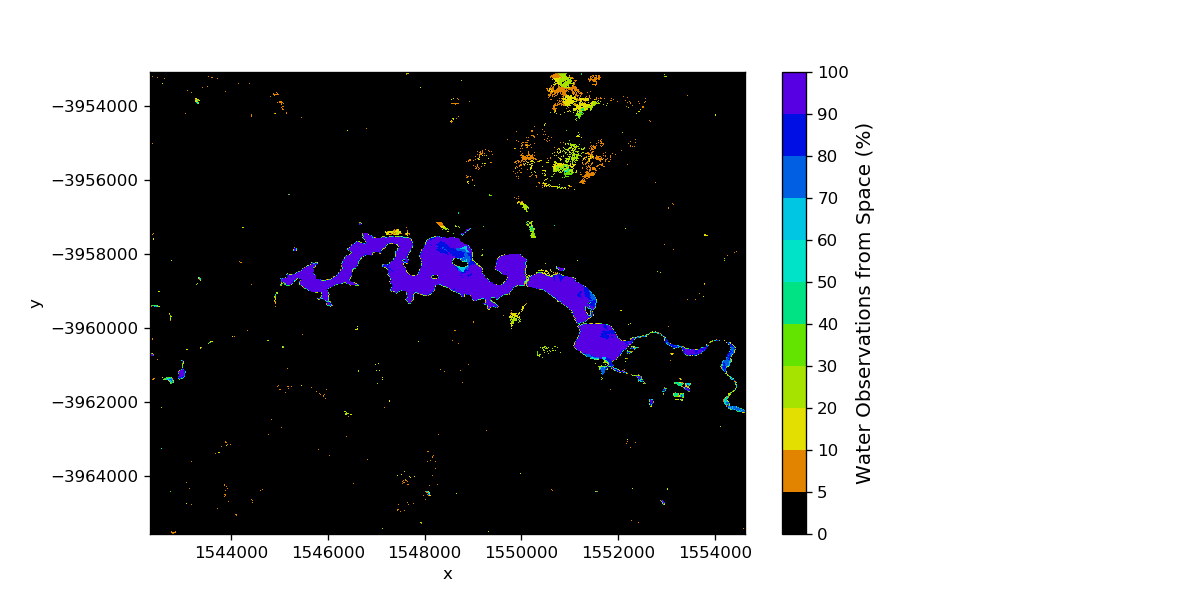

In [12]:
#Create WOfS image with specified colour ramp details
fig = plt.figure(figsize =(10,5)) 
i=s2_wofs.plot.imshow(cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100)
plt.colorbar(i, ticks=wofs_bounds, 
            ).set_label(label='Water Observations from Space (%)',
             size=12) #Add definable colour bar
fig.delaxes(fig.axes[1]) #Remove pre-defined colour bar

plt.show() #Create image

In [13]:
del(s2_dataset)
del(s2_clear_dataset)

# Explore Landsat data for the same location/date

In [4]:
ls_bands_of_interest = ['blue', 
                     'green', 
                     'red', 
                     'nir', 
                     'swir1', 
                     'swir2', ]
sensors = ['ls8','ls7']

ls_query = {'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time':('2016-01-01', '2017-12-31'),}

print(ls_query)

{'lat': (-35.25, -35.35), 'lon': (149.05, 149.17), 'time': ('2016-01-01', '2017-12-31')}


In [5]:
#temporal range is defined
start_of_epoch = '2006-01-01'
end_of_epoch =  '2017-12-31'


#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results. It should be noted the "land_sea" code will remove all ocean/sea pixels.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True,
'land_sea': 'land'}

In [6]:
#load Sentinel 2 data
#Data for each Landsat sensor is retrieved

sensor_clean = {}

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = ls_bands_of_interest,  **ls_query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **ls_query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_good = sensor_nbar2.where(cloud_free).dropna(dim='time', how='all')
    
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size)) 
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

nbar_clean = xr.concat(sensor_clean.values(), 'time')
nbar_clean = nbar_clean.sortby('time')
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine
print(nbar_clean)

ValueError: No products match search terms: {'time': Range(begin=datetime.datetime(2016, 1, 1, 0, 0, tzinfo=<UTC>), end=datetime.datetime(2017, 12, 31, 0, 0, tzinfo=<UTC>)), 'lat': Range(begin=-35.35, end=-35.25), 'lon': Range(begin=149.05, end=149.17), 'product': 'ls8_nbar_albers'}

In [17]:
#Use water clasifier function created above
warnings.filterwarnings('ignore') #turn off warnings
ls_water_class = water_classifier(nbar_clean)#_subset) #use function
warnings.filterwarnings('always') #turn on warnings
print(ls_water_class)

<xarray.Dataset>
Dimensions:  (time: 127, x: 492, y: 500)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-12T23:56:33 ...
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    wofs     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


In [18]:
del(nbar_clean)

In [19]:
#normalise each pixel by wether this pixel has been clear over time
ls_total_water_obs = ls_water_class.wofs.sum(dim='time') #create array that sums water obs for each pixel
ls_nbar_count = sensor_pq.pixelquality.count(dim='time') #create array that sums clear obs for each pixel
ls_wofs = ((ls_total_water_obs/ls_nbar_count)*100) #divide water obs by clear pixel to create wofs

<IPython.core.display.Javascript object>


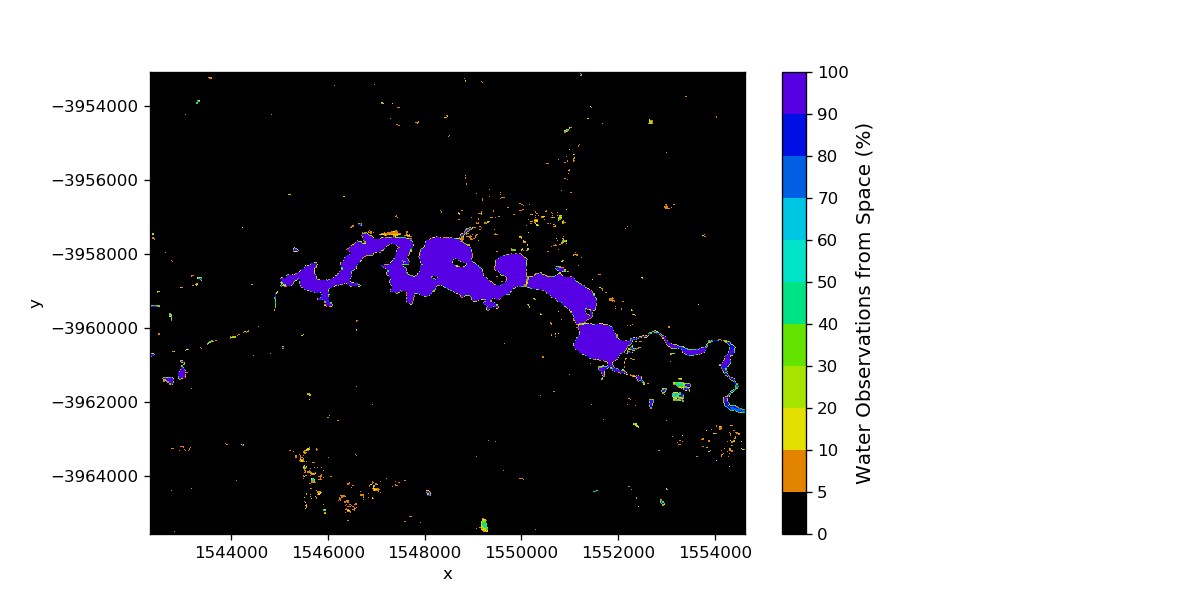

In [20]:
#Create WOfS image with specified colour ramp details
fig = plt.figure(figsize =(10,5)) 
i=ls_wofs.plot.imshow(cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100)
plt.colorbar(i, ticks=wofs_bounds, 
            ).set_label(label='Water Observations from Space (%)',
             size=12) #Add definable colour bar
fig.delaxes(fig.axes[1]) #Remove pre-defined colour bar

plt.show() #Create image